# Ground Truth generation

# table of content
1) [Generation](#generation)
2) [Addition](#addition)
3) [Erase clusters](#erase-clusters)
4) [Clean IDs of clusters](#clean-ids-of-clusters)
5) [Adapt gt semantic from gt instances](#adapt-gt-semantic-from-gt-instances)
6) [Change name of semantic and segmentation columns](#change-name-of-semantic-and-segmentation-columns)
7) [Show evolution of predicted instances vs GT](#show-evolution-of-predicted-instances-vs-gt)

Other stuff

8) [Change name of semantic and segmentation columns](#change-name-of-semantic-and-segmentation-columns)
9) [Add color field for instances](#add-color-field-for-instances)
10) [Show evolution of predicted instances vs gt](#show-evolution-of-predicted-instances-vs-gt)
11) [Fraction of the gt found + extra trees](#fraction-of-the-gt-found--extra-trees)
12) [Add new samples from preds to gt](#add-new-samples-from-preds-to-gt)
13) [Show label on tree](#show-label-on-tree)
14) [Compute mIoU](#compute-miou)

### Dependencies and general utils

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import laspy
import pdal
import json
from tqdm import tqdm

### Generation

#### Utils

In [2]:
def convert_las_to_laz(in_las, out_laz, verbose=True):
    """
    Convert a LAS file to a LAZ file, stripping all extra dimensions.

    Parameters:
    - in_las: str, path to the input .las file
    - out_laz: str, path to the output .laz file
    - verbose: bool, whether to print a success message

    Returns:
    - None
    """
    pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": in_las
            },
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip",  # Ensure compression to LAZ
            }
        ]
    }

    # Create and execute the pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()

    if verbose:
        print(f"LAZ file saved at {out_laz}")

def convert_pcd_to_laz(in_pcd, out_laz, verbose=True):
    pipeline_json = {
        "pipeline": [
            in_pcd,  # Read the PCD file
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip"  # Ensures .laz compression
                ""
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:4326",
                "out_srs": "EPSG:2056"
            }
        ]
    }

    # Run the PDAL pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()
    
    if verbose:
        print(f"LAZ file saved in {out_laz}")

def convert_laz_to_pcd(in_laz, out_pcd, verbose=True):
    laz = laspy.read(in_laz)

    # Gathering all attributes from laz file
    points = np.vstack((laz.x, laz.y, laz.z)).T

    attributes = {}
    for attribute in laz.point_format.dimensions:
        if attribute.name in ['X', 'Y', 'Z']:
            continue
        attributes[attribute.name] = getattr(laz, attribute.name)
    
    # Preparing data for pcd
    num_points = points.shape[0]
    fields = ["x", "y", "z"] + list(attributes.keys())  # All field names
    types = ["F", "F", "F"] + ["F" for _ in attributes]  # Float32 fields
    sizes = [4] * len(fields)  # 4-byte float per field

    # Stack all data into a single NumPy array
    data = np.column_stack([points] + [attributes[key] for key in attributes])

    # Write to a PCD file
    with open(out_pcd, "w") as f:
        f.write(f"VERSION 0.7\n")
        f.write(f"FIELDS {' '.join(fields)}\n")
        f.write(f"SIZE {' '.join(map(str, sizes))}\n")
        f.write(f"TYPE {' '.join(types)}\n")
        f.write(f"COUNT {' '.join(['1'] * len(fields))}\n")
        f.write(f"WIDTH {num_points}\n")
        f.write(f"HEIGHT 1\n")
        f.write(f"VIEWPOINT 0 0 0 1 0 0 0\n")
        f.write(f"POINTS {num_points}\n")
        f.write(f"DATA ascii\n")
    
        # Write data
        np.savetxt(f, data, fmt=" ".join(["%.6f"] * len(fields)))

    if verbose:
        print(f"PCD file saved in {out_pcd}")


#### Generate

In [ ]:
# Loading sources
src_folder_instances = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_4\gt"
src_original_prediction = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_4\color_grp_full_tile_331.laz"
src_folder_result = r"..\data\full_dataset\selection\clusters_4\gt"

In [ ]:
# Generate from laz to pcd for manual cleaning of the samples
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
src_pcd_loc = os.path.join(src_folder_instances, 'pcd')
os.makedirs(src_pcd_loc, exist_ok=True)
for _, file in tqdm(enumerate(files), total=len(files)):
    file_out = file.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(os.path.join(src_folder_instances, file), os.path.join(src_pcd_loc, file_out), verbose=False)

In [ ]:
# Once cleaned, generate from pcd to laz in new folder
src_folder_instances = os.path.join(src_folder_instances, 'pcd/modified_samples')
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.pcd')]
for _, file in tqdm(enumerate(files), total=len(files)):
    src_in = os.path.join(src_folder_instances, file)
    src_out = os.path.join(src_folder_instances, file.split('.pcd')[0] + '.laz')
    convert_pcd_to_laz(src_in, src_out,verbose=False)

In [ ]:
# Load original and reset/create gt columns
full_tile = laspy.read(src_original_prediction)
full_tile.add_extra_dim(laspy.ExtraBytesParams('gt_semantic',type="uint16"))
full_tile.add_extra_dim(laspy.ExtraBytesParams('gt_instance',type="uint16"))

In [ ]:
# Loop on gt instances and set the correct values in the full tile
list_instances_src = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
rounding = 2
semantic_layer = np.zeros(len(full_tile))
instance_layer = np.zeros(len(full_tile))
for id_instance, instance_src in tqdm(enumerate(list_instances_src), total=len(list_instances_src)):
    instance = laspy.read(os.path.join(src_folder_instances, instance_src))
    coords = list(zip(np.round(instance.x, rounding), np.round(instance.y, rounding), np.round(instance.z, rounding)))
    mask = np.array([(x,y,z) in coords for x, y, z in zip(np.round(full_tile.x, rounding), np.round(full_tile.y, rounding), np.round(full_tile.z, rounding))])
    semantic_layer[mask] = 1
    instance_layer[mask] = id_instance + 1

setattr(full_tile, 'gt_semantic', semantic_layer)
setattr(full_tile, 'gt_instance', instance_layer)

# save file
new_file = os.path.join(os.path.join(src_folder_result), os.path.basename(src_original_prediction).split('.laz')[0] + '_gt.laz')
full_tile.write(new_file)

### Addition

In [ ]:
# Loading sources
src_folder_instances = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_2\gt\round2"
src_target = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\gt\color_grp_full_tile_331_gt.laz"
tile_target = laspy.read(src_target)

assert "gt_semantic" in tile_target.point_format.dimension_names
assert "gt_instance" in tile_target.point_format.dimension_names

In [ ]:
# Generate from laz to pcd for manual cleaning of the samples
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
src_pcd_loc = os.path.join(src_folder_instances, 'pcd')
os.makedirs(src_pcd_loc, exist_ok=True)
for _, file in tqdm(enumerate(files), total=len(files)):
    file_out = file.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(os.path.join(src_folder_instances, file), os.path.join(src_pcd_loc, file_out), verbose=False)

In [ ]:
# Once cleaned, generate from pcd to laz in new folder
src_folder_instances = os.path.join(src_folder_instances, 'pcd/modified_samples')
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.pcd')]
for _, file in tqdm(enumerate(files), total=len(files)):
    src_in = os.path.join(src_folder_instances, file)
    src_out = os.path.join(src_folder_instances, file.split('.pcd')[0] + '.laz')
    convert_pcd_to_laz(src_in, src_out,verbose=False)

In [ ]:
# Loop on gt instances and set the correct values in the full tile
list_instances_src = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
rounding = 2
semantic_layer = np.array(tile_target.gt_semantic)
instance_layer = np.array(tile_target.gt_instance)
instance_val = np.max(tile_target.gt_instance) + 1
for id_instance, instance_src in tqdm(enumerate(list_instances_src), total=len(list_instances_src)):
    instance = laspy.read(os.path.join(src_folder_instances, instance_src))
    coords = list(zip(np.round(instance.x, rounding), np.round(instance.y, rounding), np.round(instance.z, rounding)))
    mask = np.array([(x,y,z) in coords for x, y, z in zip(np.round(tile_target.x, rounding), np.round(tile_target.y, rounding), np.round(tile_target.z, rounding))])
    semantic_layer[mask] = 1
    instance_layer[mask] = instance_val
    instance_val += 1

setattr(tile_target, 'gt_semantic', semantic_layer)
setattr(tile_target, 'gt_instance', instance_layer)


In [ ]:
# save file
new_file = os.path.join(os.path.join(src_folder_result), os.path.basename(src_target).split('.laz')[0] + '_2.laz')
tile_target.write(new_file)

### Erase clusters

In [ ]:
tree_ids_to_erase = [100]
src_tile = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\gt\color_grp_full_tile_317_gt.laz"
tile = laspy.read(src_tile)
assert "gt_instance_segmentation" in list(tile.point_format.dimension_names)

for tree_id in tree_ids_to_erase:
    mask = tile.gt_instance_segmentation == tree_id
    tile.gt_instance_segmentation[mask] = 0.0
    print(f"Tree with id {tree_id} of size {np.sum(mask)} deleted")
tile.write(src_tile)

### Clean ids of clusters

In [ ]:
src_tile = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\gt\color_grp_full_tile_317_gt.laz"
tile = laspy.read(src_tile)
assert "gt_instance_segmentation" in list(tile.point_format.dimension_names)
max_id = np.max(tile.gt_instance_segmentation)
down_jump = 0
for _, id in tqdm(enumerate(range(max_id+1)), total=max_id+1):
    mask = tile.gt_instance_segmentation == id
    if np.sum(mask) == 0:
        print(f"Empty id: {id}")
        down_jump += 1
        continue

    if down_jump > 0:
        print(id, " -> ", id - down_jump)
        tile.gt_instance_segmentation[mask] = id - down_jump
tile.write(src_tile)


### Adapt gt semantic from gt instances

In [61]:
src_tile = r"D:\PDM_repo\Github\PDM\data\gt\gt\color_grp_full_tile_331_gt.laz"
src_dest = src_tile.split('.laz')[0] + '_semantic_adapted.laz'
tile = laspy.read(src_tile)
print("Initial values:")
print(f"\t value 0.0 (grey area): {np.sum(tile.gt_semantic == 0.0)}")
print(f"\t value 1.0 (ground): {np.sum(tile.gt_semantic == 1.0)}")
print(f"\t value 4.0 (trees): {np.sum(tile.gt_semantic == 4.0)}")
for inst_num in set(tile.gt_instance):
    mask = tile.gt_instance == inst_num
    if inst_num == 0.0:
        tile.gt_semantic[mask] = 1.0
    else:
        tile.gt_semantic[mask] = 4.0
print("After adaptation:")
print(f"\t value 0.0 (grey area): {np.sum(tile.gt_semantic == 0.0)}")
print(f"\t value 1.0 (ground): {np.sum(tile.gt_semantic == 1.0)}")
print(f"\t value 4.0 (trees): {np.sum(tile.gt_semantic == 4.0)}")

tile.write(src_dest)

Initial values:
	 value 0.0 (grey area): 309680
	 value 1.0 (ground): 1490
	 value 4.0 (trees): 0
After adaptation:
	 value 0.0 (grey area): 0
	 value 1.0 (ground): 309680
	 value 4.0 (trees): 1490


### Other stuff

### Change name of semantic and segmentation columns

In [ ]:
src_tile = r"D:\PDM_repo\Github\PDM\data\gt\color_grp_full_tile_331_gt.laz"
las = laspy.read(src_tile)
for old_val, new_val in zip(['gt_semantic_segmentation', 'gt_instance_segmentation'],['gt_semantic', 'gt_instance']):
    print("Old val: ", old_val)
    print("New val: ", new_val)
    
    # Get the values
    values = las[old_val]

    # Remove the old dimension from extra dimensions (only works for ExtraBytes dimensions)
    if old_val in (las.point_format.dimension_names):
        las.remove_extra_dim(old_val)

    # Add new dimension
    las.add_extra_dim(laspy.ExtraBytesParams(name=new_val, type=np.float32))  # Change type if needed
    las[new_val] = values

# Save to new file
las.write(src_tile)

### Add color field for instances

In [ ]:
src_tile = r"D:\PDM_repo\Github\PDM\data\gt\color_grp_full_tile_317_gt.laz"

# Load file
las = laspy.read(src_tile)
instance_ids = np.array(getattr(las, "gt_instance"))
set_instances = [int(x) for x in set(instance_ids)]  # Or your instance field

# Define your custom color palette
color_map = [
    (255, 0, 0),       # Bright Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (128, 128, 0),     # Olive
    (0, 128, 0),       # Green
    (0, 255, 0),       # Bright Green
    (154, 205, 50),    # Yellow Green
    (85, 107, 47),     # Dark Olive Green
    (139, 69, 19),     # Saddle Brown
    (210, 105, 30),    # Chocolate
    (255, 105, 180),   # Hot Pink
    (255, 20, 147),    # Deep Pink
    (255, 192, 203),   # Light Pink
    (255, 0, 255),     # Magenta
    (128, 0, 128),     # Purple
    (148, 0, 211),     # Dark Violet
    (160, 82, 45),     # Sienna
    (222, 184, 135),   # Burlywood
    (255, 215, 0),     # Gold
    (218, 112, 214)    # Orchid (mild purple-pink)
]
instance_color_map = {x: color_map[x%len(color_map)] for x in set_instances}

# Assign RGB colors
r = np.zeros_like(instance_ids, dtype=np.uint16)
g = np.zeros_like(instance_ids, dtype=np.uint16)
b = np.zeros_like(instance_ids, dtype=np.uint16)

for inst_id, (r_val, g_val, b_val) in instance_color_map.items():
    mask = instance_ids == inst_id
    if inst_id == 0:
        r[mask] = 0
        g[mask] = 0
        b[mask] = 65535
    else:
        r[mask] = r_val * 256  # LAS stores 16-bit, 8-bit is scaled ×256
        g[mask] = g_val * 256
        b[mask] = b_val * 256

# Attach colors to LAS
las.red = r
las.green = g
las.blue = b

# Save new file
las.write(src_tile.split('.laz')[0] + "_colored_instances_gt.laz")

### Show evolution of predicted instances vs gt

In [75]:
src_eval = r"D:\PDM_repo\Github\PDM\results\eval\20250701_162429_final_on_gt"
src_gt = "../data/gt/gt"
tiles = [x for x in os.listdir(src_gt) if x.endswith('.laz')]
evolution = {x:[] for x in tiles}
gt_val = {x:[] for x in tiles}

# finding the number of loops
lst_loops = []
num_loop = 0
while True:
    if not str(num_loop) in os.listdir(src_eval):
        break
    lst_loops.append(num_loop)
    num_loop += 1
if num_loop == 0:
    print("No loop folder from which to extract the pseudo-labels")

gt_tiles_len = {}
for tile_src in tiles:
    tile_gt = laspy.read(os.path.join(src_gt, tile_src))
    gt_tiles_len[tile_src] = len(set(tile_gt.gt_instance)) - 1

# computing predictions and gt
for _, loop in tqdm(enumerate(range(num_loop)), total=num_loop, desc="Computing"):
    pseudo_labels = os.path.join(src_eval, str(loop), 'pseudo_labels')
    for tile_src in os.listdir(pseudo_labels):
        tile = laspy.read(os.path.join(pseudo_labels, tile_src))
        evolution[tile_src].append(len(set(tile.treeID)))
        # gt_val[tile_src].append(len(set(tile.gt_instance)))
        gt_val[tile_src].append(gt_tiles_len[tile_src])


Computing: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


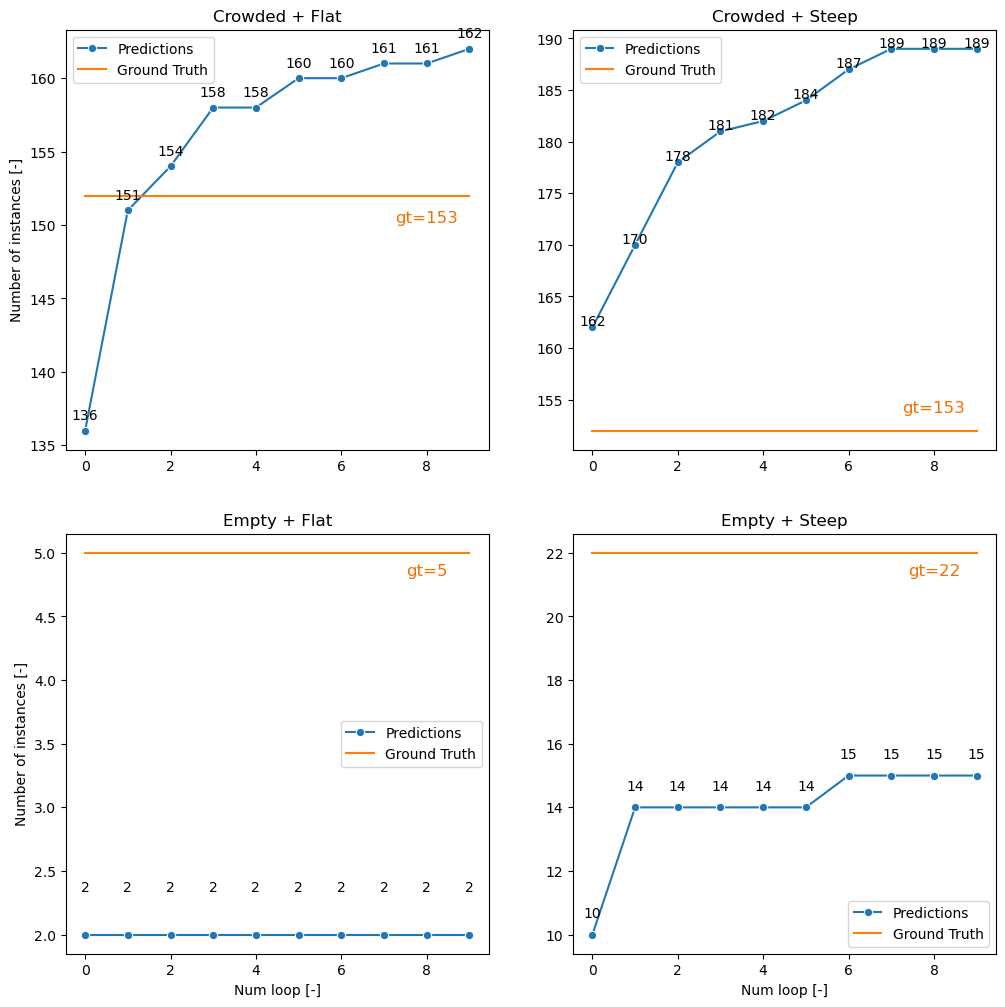

In [81]:
src_destination = r"C:\Users\swann\Documents\EPFL\Master\PDM_admin\medias\results\gt\gt_Predsvsgt.png"
src_destination = r"C:\Users\swann\Documents\EPFL\Master\PDM_admin\medias\results\gt\gt_Predsvsgt_original.png"

# show results
group_names = ['Crowded + Flat', 'Crowded + Steep', 'Empty + Flat', 'Empty + Steep']
fig, axs = plt.subplots(2,2, figsize=(12, 12))
axs = axs.flatten()
for idx, (tile, data) in enumerate(evolution.items()):
    x = np.array(range(len(data)))
    y = np.array(data)
    span = max(gt_val[tile][0], np.max(x)) - (np.min(y)-5)
    sns.lineplot(x=x, y=y, errorbar=None, marker='o', label="Predictions", ax=axs[idx])
    sns.lineplot(x=x, y=np.array(gt_val[tile]), errorbar=None, label=f"Ground Truth", ax=axs[idx])

    # Annotate each point
    for i in range(len(x)):
        axs[idx].text(x[i], y[i] + 0.8 * span / 30,  # slightly above the error bar
                f"{round(y[i],2)}",              # formatted value
                ha='center', va='bottom', fontsize=10, color='black')
    axs[idx].set_title(group_names[idx])
# axs[0].set_ylim([135, 173])
axs[0].text(8, 150, 'gt=153', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[1].text(8, 153.5, 'gt=153', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[2].text(8, 4.8, 'gt=5', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[3].text(8, 21.2, 'gt=22', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[0].set_ylabel('Number of instances [-]')
axs[2].set_ylabel('Number of instances [-]')
axs[2].set_xlabel('Num loop [-]')
axs[3].set_xlabel('Num loop [-]')
plt.savefig(src_destination)
plt.savefig(src_destination.split('.')[0] + '.eps', format='eps')
plt.show()
plt.close()

### Fraction of the gt found + extra trees

In [4]:
# utils
def remove_duplicates(laz_file, decimals=2):
    """
    Remove duplicate points from a LAS/LAZ file based on rounded coordinate precision.

    Args:
        - laz_file (laspy.LasData): Input LAS/LAZ file as a laspy object.
        - decimals (int, optional): Number of decimal places to round coordinates for duplicate detection. Defaults to 2.

    Returns:
        - laspy.LasData: A new LAS/LAZ file object with duplicates removed.
    """

    coords = np.round(np.vstack((laz_file.x, laz_file.y, laz_file.z)).T, decimals)
    _, unique_indices = np.unique(coords, axis=0, return_index=True)
    mask = np.zeros(len(coords), dtype=bool)
    mask[unique_indices] = True

    # Create new LAS object
    header = laspy.LasHeader(point_format=laz_file.header.point_format, version=laz_file.header.version)
    new_las = laspy.LasData(header)

    setattr(new_las, 'x', np.array(laz_file.x)[mask])
    setattr(new_las, 'y', np.array(laz_file.y)[mask])
    setattr(new_las, 'z', np.array(laz_file.z)[mask])
    for dim in [x for x in laz_file.point_format.dimension_names if x not in ['X', 'Y', 'Z']]:
        setattr(new_las, dim, np.array(laz_file[dim])[mask])

    return new_las


def match_pointclouds(laz1, laz2):
    """Sort laz2 to match the order of laz1 without changing laz1's order.

    Args:
        laz1: laspy.LasData object (reference order)
        laz2: laspy.LasData object (to be sorted)
    
    Returns:
        laz2 sorted to match laz1
    """
    # Retrieve and round coordinates for robust matching
    coords_1 = np.round(np.vstack((laz1.x, laz1.y, laz1.z)), 2).T
    coords_2 = np.round(np.vstack((laz2.x, laz2.y, laz2.z)), 2).T

    # Verify laz2 is of the same size as laz1
    assert len(coords_2) == len(coords_1), "laz2 should be a subset of laz1"

    # Create a dictionary mapping from coordinates to indices
    coord_to_idx = {tuple(coord): idx for idx, coord in enumerate(coords_1)}

    # Find indices in laz1 that correspond to laz2
    matching_indices = []
    failed = 0
    for coord in coords_2:
        try:
            matching_indices.append(coord_to_idx[tuple(coord)])
        except Exception as e:
            failed += 1

    matching_indices = np.array([coord_to_idx[tuple(coord)] for coord in coords_2])

    # Sort laz2 to match laz1
    sorted_indices = np.argsort(matching_indices)

    # Apply sorting to all attributes of laz2
    laz2.points = laz2.points[sorted_indices]

    return laz2  # Now sorted to match laz1



In [ ]:
src_eval = r"D:\PDM_repo\Github\PDM\results\eval\20250701_162429_final_on_gt"
src_eval = r"D:\PDM_repo\Github\PDM\results\for_paper\final\20250701_162429_final_on_gt"
src_gt = r"D:\PDM_repo\Github\PDM\data\gt\gt\color_grp_full_tile_317_gt.laz"
tile_name = "color_grp_full_tile_317_gt.laz"

do_show_extras = False

lst_num_matching = []
lst_fraction = []
lst_extras = []
lst_extras_frac = []

# finding the number of loops
lst_loops = []
num_loop = 0
while True:
    if not str(num_loop) in os.listdir(src_eval):
        break
    lst_loops.append(num_loop)
    num_loop += 1
if num_loop == 0:
    print("No loop folder from which to extract the pseudo-labels")

tile_gt = laspy.read(src_gt)
tile_gt = remove_duplicates(tile_gt)
gt_instance = tile_gt.gt_instance
num_gt = len(set(gt_instance))-1
for _, loop in tqdm(enumerate(lst_loops), total=len(lst_loops)):
    tile_src = os.path.join(src_eval, str(loop), "pseudo_labels", tile_name)
    tile_pred = laspy.read(tile_src)
    tile_pred = remove_duplicates(tile_pred)
    tile_pred = match_pointclouds(tile_gt, tile_pred)
    pred_instance = tile_pred.treeID
    num_matching = 0
    num_extras = 0

    # gt instances found
    for inst_gt in set(gt_instance):
        mask_gt = gt_instance == inst_gt
        cooresponding_instances = set(pred_instance[mask_gt])

        for inst in cooresponding_instances:
            if inst == 0.0:
                continue

            mask_other = pred_instance == inst
            
            # test iou > 0.5
            iou = (mask_gt & mask_other).sum() / (mask_gt | mask_other).sum()
            if iou > 0.5:
                num_matching += 1
                break

    # extra found
    for inst_pred in set(pred_instance):
        mask_pred = pred_instance == inst_pred
        cooresponding_instances = set(gt_instance[mask_pred])

        is_extra = True
        for inst in cooresponding_instances:
            if inst == 0.0:
                continue

            mask_other = gt_instance == inst
            
            # test iou > 0.5
            iou = (mask_pred & mask_other).sum() / (mask_pred | mask_other).sum()
            if iou > 0.5:
                is_extra = False
                break
        if is_extra == True:
            if do_show_extras:
                print(f"Extra tree: {inst_pred}")
            num_extras += 1

    lst_num_matching.append(num_matching)
    lst_fraction.append(num_matching / len(set(gt_instance)))
    lst_extras.append(num_extras)
    lst_extras_frac.append(num_extras/len(set(gt_instance)))


[49 55 59 62 63 65 67 68 68 68]


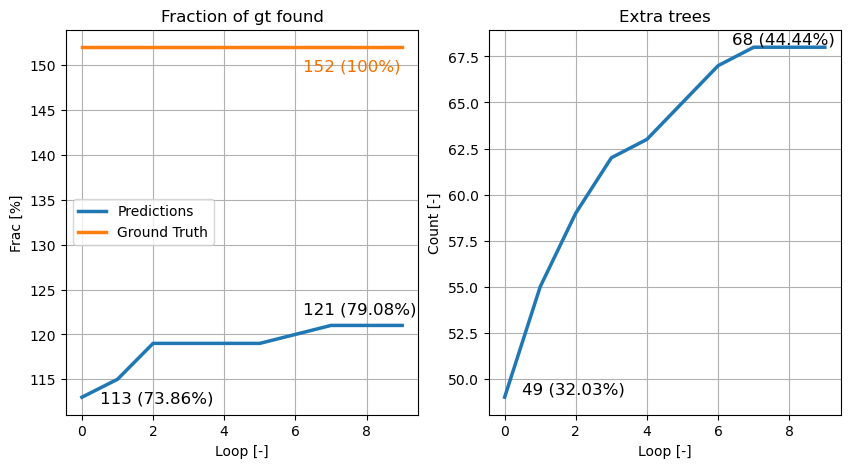

In [ ]:
src_destination = r"C:\Users\swann\Documents\EPFL\Master\PDM_admin\medias\results\gt\gt_Predsvsgt_extra.png"

# show results
group_names = ['Crowded + Flat', 'Crowded + Steep', 'Empty + Steep', 'Empty + Flat']
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs = axs.flatten()


x = np.array(range(len(lst_num_matching)))
y = np.array(lst_num_matching)
sns.lineplot(x=x, y=y, errorbar=None, linewidth=2.5, label="Predictions", ax=axs[0])
sns.lineplot(x=x, y=num_gt * np.ones(x.shape[0]), linewidth=2.5, errorbar=None, label=f"Ground Truth", ax=axs[0])
axs[0].text(0.5, lst_num_matching[0] - 1, f'{lst_num_matching[0]} ({round(lst_fraction[0]*100,2)}%)', ha='left', va='bottom', fontsize=12)
axs[0].text(6.2, lst_num_matching[-1] + 1, f'{lst_num_matching[-1]} ({round(lst_fraction[-1] * 100, 2)}%)', ha='left', va='bottom', fontsize=12)
axs[0].text(6.2, num_gt - 3, f'{num_gt} (100%)', ha='left', va='bottom', color='#f67000', fontsize=12)
axs[0].legend(loc="center left")
axs[0].grid()
axs[0].set_title("Fraction of gt found")
axs[0].set_xlabel('Loop [-]')
axs[0].set_ylabel('Frac [%]')

y = np.array(lst_extras)
# print(y)
sns.lineplot(x=x, y=y, errorbar=None, linewidth=2.5, ax=axs[1])
axs[1].text(0.5, lst_extras[0], f'{lst_extras[0]} ({round(lst_extras_frac[0]*100,2)}%)', ha='left', va='bottom', fontsize=12)
axs[1].text(6.4, lst_extras[-1], f'{lst_extras[-1]} ({round(lst_extras_frac[-1] * 100, 2)}%)', ha='left', va='bottom', fontsize=12)
axs[1].grid()
# axs[1].set_ylim([7.5, 40])
axs[1].set_title("Extra trees")
axs[1].set_xlabel('Loop [-]')
axs[1].set_ylabel('Count [-]')

# plt.savefig(src_destination)
# plt.savefig(src_destination.split('.')[0] + '.eps', format='eps')
plt.show()
plt.close()

In [ ]:
src_destination = r"C:\Users\swann\Documents\EPFL\Master\PDM_admin\medias\results\gt\gt_Predsvsgt.png"

# show results
group_names = ['Crowded + Flat', 'Crowded + Steep', 'Empty + Steep', 'Empty + Flat']
fig, axs = plt.subplots(2,2, figsize=(12, 12))
axs = axs.flatten()
for idx, (tile, data) in enumerate(evolution.items()):
    x = np.array(range(len(data)))
    y = np.array(data)
    span = max(gt_val[tile][0], np.max(x)) - (np.min(y)-5)
    sns.lineplot(x=x, y=y, errorbar=None, marker='o', label="Predictions", ax=axs[idx])
    sns.lineplot(x=x, y=np.array(gt_val[tile]), errorbar=None, label=f"Ground Truth", ax=axs[idx])

    # Annotate each point
    for i in range(len(x)):
        axs[idx].text(x[i], y[i] + 0.8 * span / 30,  # slightly above the error bar
                f"{round(y[i],2)}",              # formatted value
                ha='center', va='bottom', fontsize=10, color='black')
    axs[idx].set_title(group_names[idx])
# axs[0].set_ylim([135, 173])
axs[0].text(8, 179, 'gt=182', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[1].text(8, 197.5, 'gt=200', ha='center', va='bottom', fontsize=12, color='#f67000')
# axs[2].text(8, 4.8, 'gt=5', ha='center', va='bottom', fontsize=12, color='#f67000')
# axs[3].text(8, 21.2, 'gt=22', ha='center', va='bottom', fontsize=12, color='#f67000')
# plt.savefig(src_destination)
# plt.savefig(src_destination.split('.')[0] + '.eps', format='eps')
plt.show()
plt.close()

### Add new samples from preds to gt

In [ ]:
from sklearn.decomposition import PCA

def transform_with_pca(pointcloud, verbose=False):
    """
    Transform a 2D or 3D point cloud using Principal Component Analysis (PCA) to align with principal axes.

    Args:
        - pointcloud (np.ndarray): Input point cloud as a numpy array of shape (N, 2) or (N, 3).
        - verbose (bool, optional): Whether to print PCA components and transformed points. Defaults to False.

    Returns:
        - np.ndarray: PCA-transformed point cloud of shape (N, 2).
    """

    # fit PCA
    pca = PCA(n_components=2)

    # compute pointcloud in new axes
    transformed = pca.fit_transform(pointcloud)

    # principal axes
    components = pca.components_  
    if verbose:
        print("PCA components (axes):\n", components)
        print("PCA-transformed points:\n", transformed)
    
    return transformed

def split_instances(pointcloud, maskA, maskB):
    """
    Split overlapping instances within a point cloud using PCA to determine a separation line.

    Args:
        - pointcloud (laspy.LasData): Input LAS/LAZ point cloud.
        - maskA (np.ndarray): Boolean mask for instance A.
        - maskB (np.ndarray): Boolean mask for instance B.

    Returns:
        - tuple[np.ndarray, np.ndarray]: Updated boolean masks (maskA, maskB) after splitting the intersection region based on proximity to instance centroids.
    """

    intersection_mask = maskA & maskB
    pc_x = np.reshape(np.array(getattr(pointcloud, 'x')), (-1,1))
    pc_y = np.reshape(np.array(getattr(pointcloud, 'y')), (-1,1))

    pc_A = np.concatenate((pc_x[maskA], pc_y[maskA]), axis=1)
    pc_B = np.concatenate((pc_x[maskB], pc_y[maskB]), axis=1)

    intersection = np.concatenate((pc_x[intersection_mask], pc_y[intersection_mask]), axis=1)        
    intersection_transformed = transform_with_pca(intersection)

    # cut
    mask_pos = intersection_transformed[:,1] > 0
    mask_neg = mask_pos == False
    mask_pos_full = np.zeros((len(intersection_mask)))
    mask_neg_full = np.zeros((len(intersection_mask)))
    small_pos = 0
    small_neg = 0
    for i in range(len(intersection_mask)):
        if intersection_mask[i]:
            mask_pos_full[i] = mask_pos[small_pos]
            small_pos += 1
    for i in range(len(intersection_mask)):
        if intersection_mask[i]:
            mask_neg_full[i] = mask_neg[small_neg]
            small_neg += 1

    # find centroids of the two clusters:
    centroid_A = np.mean(pc_A, axis=0)
    centroid_B = np.mean(pc_B, axis=0)

    centroid_pos = np.mean(intersection[mask_pos], axis=0)

    dist_pos_A = ((centroid_A[0] - centroid_pos[0])**2 + (centroid_A[1] - centroid_pos[1])**2)**0.5
    dist_pos_B = ((centroid_B[0] - centroid_pos[0])**2 + (centroid_B[1] - centroid_pos[1])**2)**0.5

    # remove intersection from masks
    anti_intersection_mask = intersection_mask == False
    maskA = maskA.astype(bool) & anti_intersection_mask.astype(bool)
    maskB = maskB.astype(bool) & anti_intersection_mask.astype(bool)

    # add part of intersection to each mask
    if dist_pos_A < dist_pos_B:
        maskA = (maskA.astype(bool) | mask_pos_full.astype(bool))
        maskB = (maskB.astype(bool) | mask_neg_full.astype(bool))
    else:
        maskA = (maskA.astype(bool) | mask_neg_full.astype(bool))
        maskB = (maskB.astype(bool) | mask_pos_full.astype(bool))
    
    return maskA, maskB

def clean_ids_instances(tile, field_name, verbose=False):
    assert field_name in list(tile.point_format.dimension_names)
    field = getattr(tile, field_name)
    max_id = np.max(field)
    down_jump = 0
    for _, id in tqdm(enumerate(range(int(max_id)+1)), total=int(max_id)+1):
        mask = field == id
        if np.sum(mask) == 0:
            if verbose:
                print(f"Empty id: {id}")
            down_jump += 1
            continue

        if down_jump > 0:
            if verbose:
                print(id, " -> ", id - down_jump)
            field[mask] = id - down_jump
    setattr(tile, field_name,field)


In [ ]:
src_tile = r"D:\PDM_repo\Github\PDM\results\for_paper\final\20250701_162429_final_on_gt\pseudo_labels\color_grp_full_tile_316_gt.laz"
src_dest = ''.join(src_tile.split('.')[:-1]) + "_extended_with_preds.laz"
import sys
import os
from omegaconf import OmegaConf
sys.path.append(os.path.dirname(os.getcwd()))
from src.fast_inference import fast_inference
args_classifier = OmegaConf.load("../models/KDE_classifier/config/inference.yaml")
tile = laspy.read(src_tile)
preds = tile.treeID
gt = tile.gt_instance

# remove preselected instances in gt
lst_to_remove = []

for el in lst_to_remove:
    gt[gt == el] = 0
clean_ids_instances(tile, 'gt_instance')
id_new_tree = len(set(gt))
tracking_pred = []
dict_monitoring = {x:0 for x in ['total', 'new_instance', 'is_ground', 'same_heighest_point', 'overlapping_greater_than_2', 'i_o_new_tree_greater_than_70_per', 'i_o_other_tree_greater_than_70_per', 'splitting_using_pca', 'not_a_tree_after_splitting']}
for inst_pred in tqdm(set(preds)):
    is_new_tree = True
    if inst_pred == 0.0:
        continue
    mask = preds == inst_pred
    overlapping_gt = [x for x in set(gt[mask]) if x != 0.0]
    
    for inst_gt in overlapping_gt:
            if inst_gt == 0.0:
                continue
            
            other_tree_mask = gt == inst_gt
            new_file_x = np.array(getattr(tile, 'x')).reshape((-1,1))
            new_file_y = np.array(getattr(tile, 'y')).reshape((-1,1))
            new_file_z = np.array(getattr(tile, 'z')).reshape((-1,1))
            pointCloud = np.stack([new_file_x, new_file_y, new_file_z], axis=1)

            # Compare heighest points
            if np.max(new_file_z[mask]) == np.max(new_file_z[other_tree_mask]):
                dict_monitoring["same_heighest_point"] += 1
                is_new_tree = False
                if inst_pred in tracking_pred:
                    print(f'1 - {inst_pred} with {inst_gt}')
            
            # Get intersection
            intersection_mask = mask & other_tree_mask
            if np.sum(intersection_mask) > 1:
                intersection = np.concatenate((new_file_x, new_file_y), axis=1)[intersection_mask]

                # Check radius of intersection
                intersection_pca = transform_with_pca(intersection)
                small_range = np.max(intersection_pca[:,1]) - np.min(intersection_pca[:,1])
                if small_range > 2:
                    is_new_tree = False
                    dict_monitoring["overlapping_greater_than_2"] += 1
                    if inst_pred in tracking_pred:
                        print(f'2 - {inst_pred} with {inst_gt}')

            # Intersection over new tree
            if np.sum(intersection_mask) / np.sum(mask) > 0.7:
                is_new_tree = False
                dict_monitoring["i_o_new_tree_greater_than_70_per"] += 1
                if inst_pred in tracking_pred:
                    print(f'3 - {inst_pred} with {inst_gt}')

            # Intersection over other tree
            if np.sum(intersection_mask) / np.sum(other_tree_mask) > 0.7:
                is_new_tree = False
                dict_monitoring["i_o_other_tree_greater_than_70_per"] += 1
                if inst_pred in tracking_pred:
                    print(f'4 - {inst_pred} with {inst_gt}')
                
            if is_new_tree == False:
                dict_monitoring["total"] += 1

    if is_new_tree == True:
        # Update instances
        if len(set(overlapping_gt)) > 1:
            for instance in set(overlapping_gt):
                # Don't split if ground
                if instance == 0:
                    continue

                # Don't split if intersection too small
                intersection_mask = mask & other_tree_mask
                if np.sum(intersection_mask) < 2:
                    continue

                # Splitting
                dict_monitoring["splitting_using_pca"] += 1
                other_tree_mask = tile.treeID == instance
                intersection_mask = mask & other_tree_mask
                if np.sum(intersection_mask) > 1:
                    mask, new_other_tree_mask = split_instances(new_file, mask, other_tree_mask)
                else:
                    new_other_tree_mask = (other_tree_mask.astype(int) - intersection_mask.astype(int)).astype(bool)

                # Check if splitted instances are still predicted as trees
                tree_1 = pointCloud[mask]
                tree_2 = pointCloud[new_other_tree_mask]
                preds_classifier = fast_inference([tree_1, tree_2], args_classifier)

                # Stop adding the new instance if any of the two are not predicted as tree anymore
                if np.any(np.argmax(preds_classifier, axis=1) != 2):
                    dict_monitoring["not_a_tree_after_splitting"] += 1
                    is_new_tree = False
                    break

        if is_new_tree:
            dict_monitoring["new_instance"] += 1
            # update classification
            tile.gt_semantic[mask] = 4

            # update instance
            tile.gt_instance[mask] = id_new_tree
            # print(f"Instance {inst_pred} added as {id_new_tree}")
            id_new_tree += 1

Number of gt before cleaning:  141


100%|██████████| 153/153 [00:00<00:00, 396.08it/s]


Down jump:  12
Number of gt after cleaning:  141


100%|██████████| 162/162 [00:21<00:00,  7.68it/s]


In [19]:
print("Number of gt: ", len(set(tile.gt_instance)))
print("Max gt: ", max(set(tile.gt_instance)))

Number of gt:  183
Max gt:  182.0


In [20]:
# saving
tile.write(src_dest)

### Show label on tree

In [35]:
# src_tile = r"D:\PDM_repo\Github\PDM\results\for_paper\final\20250701_162429_final_on_gt\pseudo_labels\color_grp_full_tile_317_gt.laz"
src_tile = r"D:\PDM_repo\Github\PDM\data\gt\gt\color_grp_full_tile_317_gt.laz"
var_name = "gt_instance"
# Load file
las = laspy.read(src_tile)
# las  = tile
instance_ids = np.array(getattr(las, var_name))
set_instances = [int(x) for x in set(instance_ids)]  # Or your instance field

# Define your custom color palette
color_map = [
    (255, 0, 0),       # Bright Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (128, 128, 0),     # Olive
    (0, 128, 0),       # Green
    (0, 255, 0),       # Bright Green
    (154, 205, 50),    # Yellow Green
    (85, 107, 47),     # Dark Olive Green
    (139, 69, 19),     # Saddle Brown
    (210, 105, 30),    # Chocolate
    (255, 105, 180),   # Hot Pink
    (255, 20, 147),    # Deep Pink
    (255, 192, 203),   # Light Pink
    (255, 0, 255),     # Magenta
    (128, 0, 128),     # Purple
    (148, 0, 211),     # Dark Violet
    (160, 82, 45),     # Sienna
    (222, 184, 135),   # Burlywood
    (255, 215, 0),     # Gold
    (218, 112, 214)    # Orchid (mild purple-pink)
]
instance_color_map = {x: color_map[x%len(color_map)] for x in set_instances}

# Assign RGB colors
r = np.zeros_like(instance_ids, dtype=np.uint16)
g = np.zeros_like(instance_ids, dtype=np.uint16)
b = np.zeros_like(instance_ids, dtype=np.uint16)

for inst_id, (r_val, g_val, b_val) in instance_color_map.items():
    mask = instance_ids == inst_id
    if inst_id == 0:
        r[mask] = 0
        g[mask] = 0
        b[mask] = 65535
    else:
        r[mask] = r_val * 256  # LAS stores 16-bit, 8-bit is scaled ×256
        g[mask] = g_val * 256
        b[mask] = b_val * 256

# Attach colors to LAS
las.red = r
las.green = g
las.blue = b

# Save new file
# las.write(src_tile.split('.laz')[0] + "_colored_instances_pseudo_labels.laz")

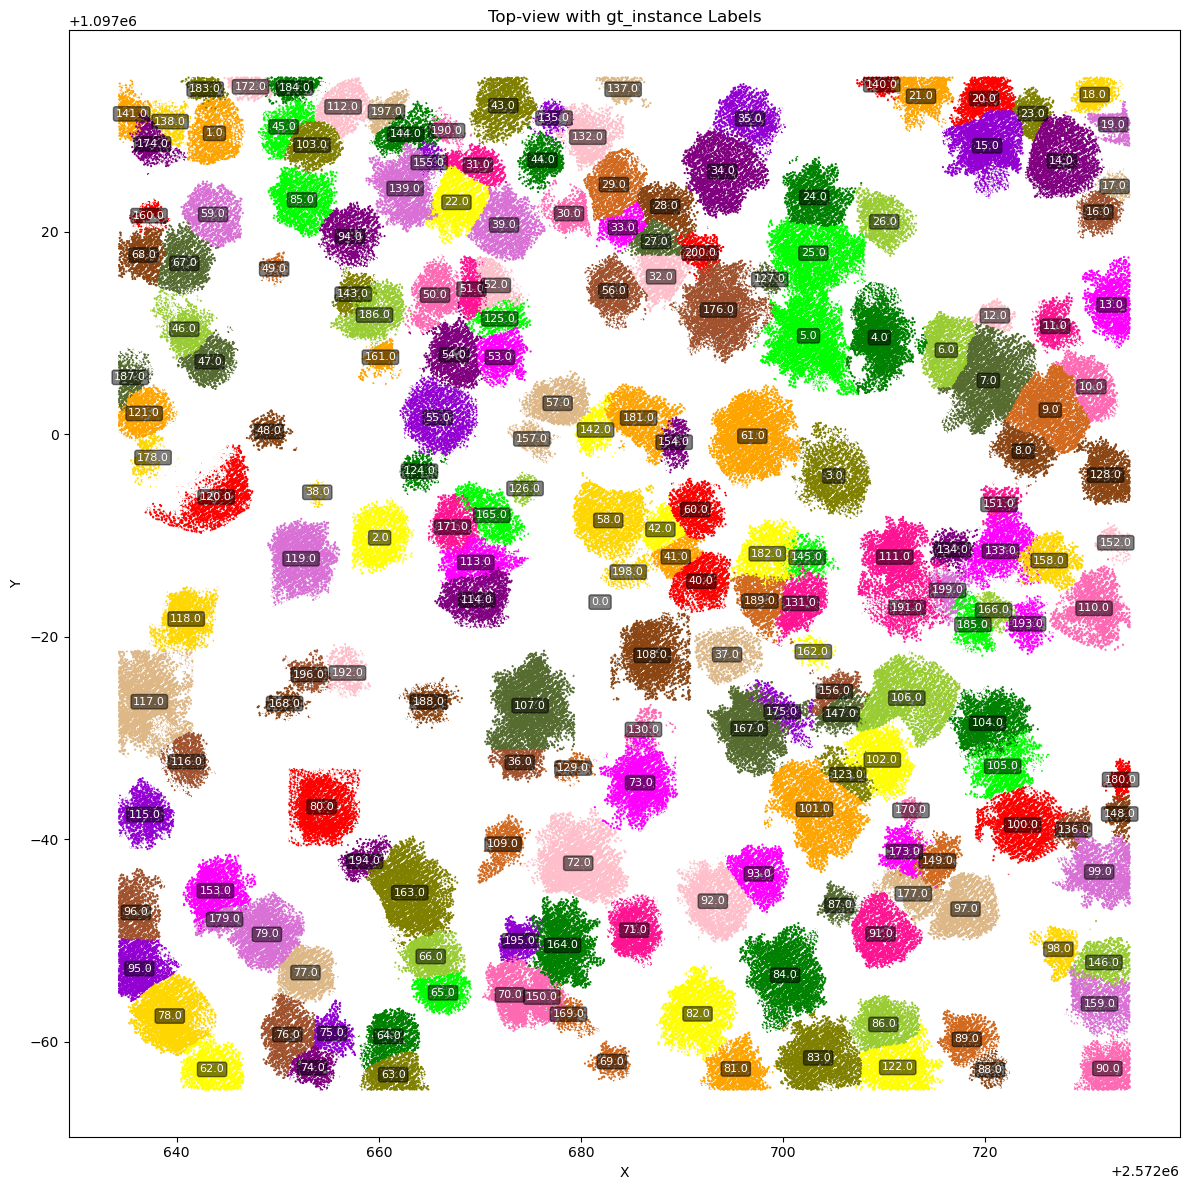

In [36]:
import laspy
import matplotlib.pyplot as plt
import numpy as np

# Extract coordinates and gt_instance labels
x = las.x
y = las.y
z = las.z  # optional, for coloring
gt_instance = getattr(las, var_name)

# Extract RGB values and normalize to [0, 1]
mask_floor = getattr(las, var_name) == 0.0
las.red[mask_floor] = 65535.0
las.green[mask_floor] = 65535.0
las.blue[mask_floor] = 65535.0
r = las.red / 65535.0
g = las.green / 65535.0
b = las.blue / 65535.0
colors = np.vstack((r, g, b)).T

# Plot the point cloud colored by Z
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=colors, s=10, marker='.', linewidths=0)

# Compute centroids and overlay labels
unique_labels = np.unique(gt_instance)
for label in unique_labels:
    if label == -1:
        continue  # skip unlabelled points if any
    mask = gt_instance == label
    x_mean = np.mean(x[mask])
    y_mean = np.mean(y[mask])
    if label != 99999:
        plt.text(x_mean, y_mean, str(label), fontsize=8, color='white',
                 ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Final touches
plt.axis('equal')
plt.title(f"Top-view with {var_name} Labels")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


### Compute mIoU

#### Utils

In [66]:
def compute_mean_iou_semantic(y_true, y_pred, list_classes):
    """
    Computes mean Intersection over Union (mIoU) for a set of ground truth and predicted labels.

    Args:
        - y_true (numpy.ndarray): Ground truth labels (N,).
        - y_pred (numpy.ndarray): Predicted labels (N,).
        - num_classes (int, optional): Total number of classes (default is 2).

    Returns:
        - float: Mean IoU score.
    """

    iou_list = []
    
    for c in list_classes:
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        iou_list.append(iou)

    return np.mean(iou_list)


def compute_mean_iou_instances(y_true, y_pred, th=0.5, do_output_each_val=False):
    """
    Computes mean Intersection over Union (mIoU) for a set of ground truth and predicted labels.

    Args:
        - y_true (numpy.ndarray): Ground truth labels (N,).
        - y_pred (numpy.ndarray): Predicted labels (N,).
        - th (float, optional): Threshold to take into account the instances or not (default is 0.5).

    Returns:
        - float: Mean IoU score.
    """
    
    iou_list = []

    for inst_gt in set(y_true):
        if inst_gt == 0.0:
            continue
        mask_gt = y_true == inst_gt
        cooresponding_instances = set(y_pred[mask_gt])
        best_iou = 0.0
        for inst in cooresponding_instances:
            if inst == 0.0:
                continue

            mask_other = y_pred == inst
            
            # test iou > th
            iou = (mask_gt & mask_other).sum() / (mask_gt | mask_other).sum()
            if iou > th and iou > best_iou:
                 best_iou = iou
        iou_list.append(best_iou)

    if do_output_each_val:
        return np.mean(iou_list), iou_list
    else:
        return np.mean(iou_list)


In [70]:
src_tile = r"D:\PDM_repo\Github\PDM\data\gt\gt\color_grp_full_tile_317_gt.laz"

do_output_list = True

tile = laspy.read(src_tile)

gt_semantic = tile.gt_semantic
gt_instances = tile.gt_instance
pred_semantic = tile.classification
pred_instances = tile.treeID

mIoU_semantic = compute_mean_iou_semantic(gt_semantic, pred_semantic, [1.0, 4.0])
mIoU_instance = compute_mean_iou_instances(gt_instances, pred_instances, 0.0, do_output_list)
if do_output_list:
    mIoU_instance, list_IoUs = mIoU_instance

print("Mean IoU on semantic field: ", mIoU_semantic)
print("Mean IoU on instance field: ", mIoU_instance)

if do_output_list:
    src_list_iou = src_tile.split('.laz')[0] + '_IoU_list.txt'
    with open(src_list_iou, 'w') as f:
        for line in list_IoUs:
            f.write(f"{line}\n")


Mean IoU on semantic field:  0.7612946335204782
Mean IoU on instance field:  0.7957901254247485
